In [1]:
from util import locate_directory, get_image_T, get_cropped_image_old, calculate_gncc
import deepreg.model.layer as layer
import glob
import h5py
import json
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt

In [97]:
def overlay_matrices(matrix1, matrix2, dim, contrast_factor=1, title="Image Overlay"):
    """
    Create a plot that overlays the MIPs of two matrices along a specified dimension.
    
    Parameters:
    - matrix1, matrix2 (np.array): 3D numpy arrays.
    - dim (int): The dimension along which to compute and overlay the MIPs.
    - contrast_factor (float): Factor by which to divide the maximum intensity 
                               to increase the image contrast. Must be >= 1.
    """
    # Ensure the matrices are 3D
    if matrix1.ndim != 3 or matrix2.ndim != 3:
        raise ValueError("Input matrices must be 3D")
    
    # Ensure contrast_factor is valid
    if contrast_factor < 1:
        raise ValueError("contrast_factor must be >= 1")
    
    # Compute MIPs
    mip1 = np.max(matrix1, dim)
    mip2 = np.max(matrix2, dim)
    
    # Ensure MIPs are 2D
    if mip1.ndim != 2 or mip2.ndim != 2:
        raise ValueError("MIPs must be 2D")
    
    # Normalize MIPs to [0, 1] based on the adjusted maximum values
    mip1_norm = mip1 / (np.max(mip1) / contrast_factor)
    mip2_norm = mip2 / (np.max(mip2) / contrast_factor)
    
    # Ensure values are clipped to [0, 1] after adjusting contrast
    mip1_norm = np.clip(mip1_norm, 0, 1)
    mip2_norm = np.clip(mip2_norm, 0, 1)
    
    # Create an RGB image: R corresponds to mip1, G to mip2, B is kept 0
    rgb_image = np.stack([mip1_norm, mip2_norm, np.zeros_like(mip1_norm)], axis=-1)
    
    # Create a figure and axis for the plot
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot the RGB image
    ax.imshow(rgb_image, origin='lower')
    
    # Add a title and show the plot
    ax.set_title(title)
    plt.show()

In [106]:
# ckpt = "20230727-232311_affinenet-0"
ckpt = "20230721-094718"
base = "/home/alicia/data_personal/regnet_ckpt/logs_predict"
# pair_num = 6
pair_num = 5
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

dataset_type_n_name = 'test/2022-04-14-04'
dataset_type, dataset_name = dataset_type_n_name.split('/')
data_path = locate_directory(dataset_name)

# problem = '106to410'
problem = "1062to1528"

t_moving, t_fixed = problem.split('to')

t_moving_4 = t_moving.zfill(4)
moving_image_source_path =  glob.glob(f"{data_path}/NRRD_filtered/*_t{t_moving_4}_ch2.nrrd")[0]
moving_image_source = get_image_T(moving_image_source_path)

resized_moving_image_source = get_cropped_image_old(moving_image_source)

t_fixed_4 = t_fixed.zfill(4)
fixed_image_source_path =  glob.glob(f"{data_path}/NRRD_filtered/*_t{t_fixed_4}_ch2.nrrd")[0]
fixed_image_source = get_image_T(fixed_image_source_path)

resized_fixed_image_source = get_cropped_image_old(fixed_image_source)

print(f"original fixed image shape: {fixed_image_source.shape}")
print(f"original moving image shape: {moving_image_source.shape}")


original fixed image shape: (211, 97, 53)
original moving image shape: (227, 97, 53)


In [107]:
fixed_image_x, fixed_image_y, fixed_image_z = fixed_image_source.shape
moving_image_x, moving_image_y, moving_image_z = moving_image_source.shape

In [108]:
fixed_image_x, fixed_image_y, fixed_image_z

(211, 97, 53)

In [109]:
moving_image_x, moving_image_y, moving_image_z

(227, 97, 53)

### examine ch2 images

In [110]:
import glob

ddf_nii_path = f"{base}/{ckpt}/test/pair_{pair_num}/ddf.nii.gz"
ddf_array = nib.load(ddf_nii_path).get_fdata()

moving_image_nii_path = f"{base}/{ckpt}/test/pair_{pair_num}/moving_image.nii.gz"
moving_image = nib.load(moving_image_nii_path).get_fdata()

fixed_image_nii_path = f"{base}/{ckpt}/test/pair_{pair_num}/fixed_image.nii.gz"
fixed_image = nib.load(fixed_image_nii_path).get_fdata()

pred_fixed_image_nii_path = f"{base}/{ckpt}/test/pair_{pair_num}/pred_fixed_image.nii.gz"
pred_fixed_image = nib.load(pred_fixed_image_nii_path).get_fdata()

resized_fixed_image_tf = tf.cast(tf.expand_dims(fixed_image, axis=0), dtype=tf.float32)
resized_moving_image_tf = tf.cast(tf.expand_dims(moving_image, axis=0), dtype=tf.float32)

warping = layer.Warping(fixed_image_size=resized_fixed_image_tf.shape[1:4])
warped_moving_image_tf = warping(inputs=[ddf_array, resized_moving_image_tf])
warped_moving_image = warped_moving_image_tf.numpy()[0]

GNCC: 0.9006984725565855


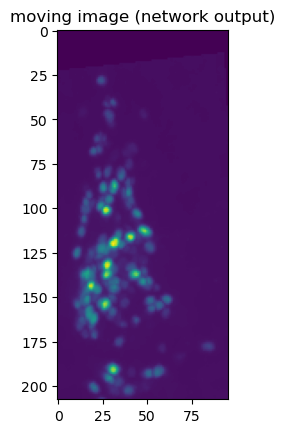

In [111]:
plt.imshow(moving_image.max(2));
plt.title("moving image (network output)");
print(f"GNCC: {calculate_gncc(fixed_image, moving_image)}")

GNCC: 0.8212716731939156


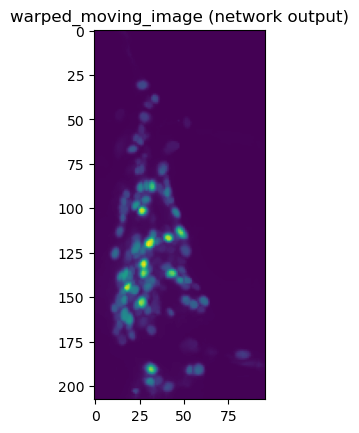

In [112]:
plt.imshow(warped_moving_image.max(2));
plt.title("warped_moving_image (network output)");
print(f"GNCC: {calculate_gncc(fixed_image, warped_moving_image)}")

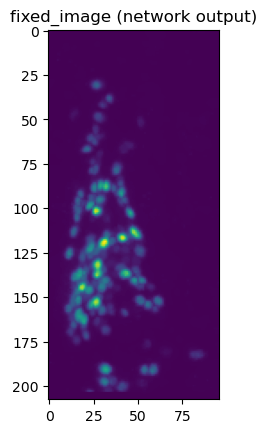

In [113]:
plt.imshow(fixed_image.max(2));
plt.title("fixed_image (network output)");

In [121]:
ddf_nii_path = f"{base}/{ckpt}/test/pair_{pair_num}/ddf.nii.gz"
ddf_array = nib.load(ddf_nii_path).get_fdata()

fixed_roi_image_path = f"{data_path}/img_roi_watershed/{t_fixed}.nrrd"
moving_roi_image_path = f"{data_path}/img_roi_watershed/{t_moving}.nrrd"

fixed_roi_image_T = get_image_T(fixed_roi_image_path)
print(f"fixed image ROI shape: {fixed_roi_image_T.shape}")
moving_roi_image_T = get_image_T(moving_roi_image_path)
print(f"moving image ROI shape: {moving_roi_image_T.shape}")

resized_fixed_roi_image = get_cropped_image_old(
        fixed_roi_image_T)

resized_moving_roi_image = get_cropped_image_old(
        moving_roi_image_T)

resized_fixed_roi_image_tf = tf.cast(tf.expand_dims(resized_fixed_roi_image,
    axis=0), dtype=tf.float32)
resized_moving_roi_image_tf = tf.cast(tf.expand_dims(resized_moving_roi_image,
    axis=0), dtype=tf.float32)

warping = layer.Warping(fixed_image_size=resized_fixed_roi_image_tf.shape[1:4],
                        interpolation="linear")
warped_moving_roi_image_tf = warping(inputs=[ddf_array, resized_moving_roi_image_tf])
warped_moving_roi_image = warped_moving_roi_image_tf.numpy()[0]

fixed image ROI shape: (211, 97, 53)
moving image ROI shape: (227, 97, 53)


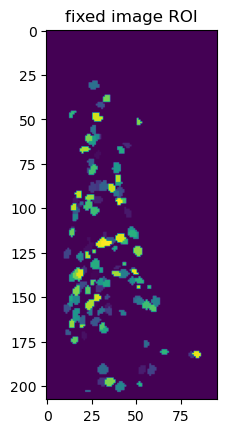

In [122]:
plt.imshow(resized_fixed_roi_image.max(2));
plt.title("fixed image ROI");

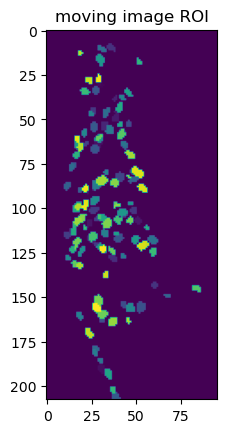

In [123]:
plt.imshow(resized_moving_roi_image.max(2));
plt.title('moving image ROI');

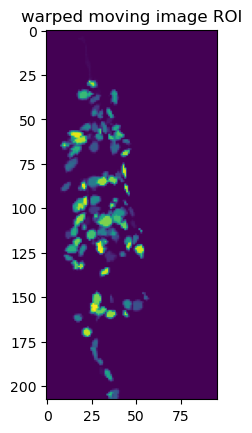

In [124]:
plt.imshow(warped_moving_roi_image.max(2));
plt.title("warped moving image ROI");

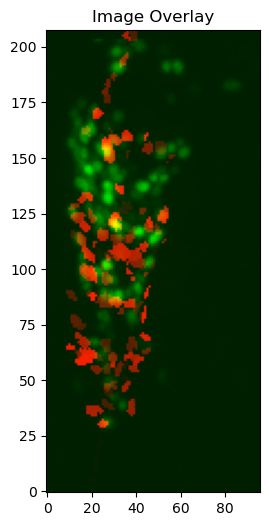

In [118]:
overlay_matrices(warped_moving_roi_image, fixed_image, 2)

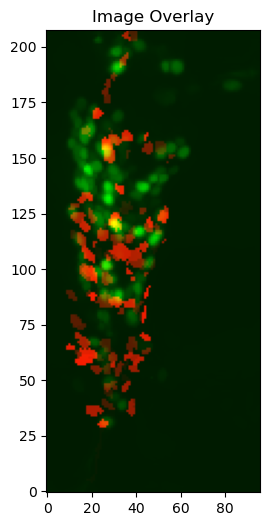

In [119]:
overlay_matrices(warped_moving_roi_image, warped_moving_image, 2)

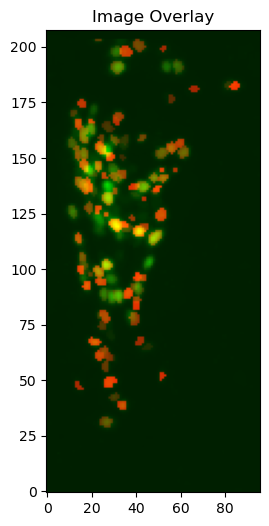

In [120]:
overlay_matrices(resized_fixed_roi_image, fixed_image, 2)

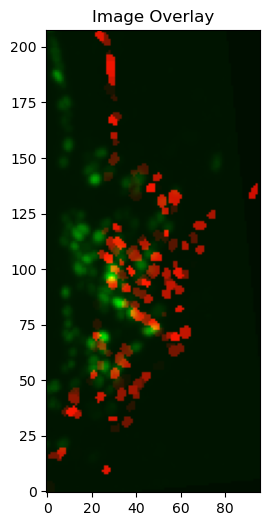

In [105]:
overlay_matrices(resized_moving_roi_image, moving_image, 2)